In [266]:
import cv2 as cv
import numpy as np
from PIL import Image
import tempfile
import warnings
warnings.filterwarnings('ignore')

In [267]:
def set_image_dpi(file_path):       # Set image dpi for OCR engine
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def image_binarisation(img):        # Use Otsu's binarisation
    blur = cv.GaussianBlur(img,(3,3),0)
    ret,th = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def image_noise_removal(img):       # Remove noise from image
    im_nr = cv.fastNlMeansDenoising(img, 30.0, 7, 21)
    return im_nr

In [268]:
import cv2 as cv
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

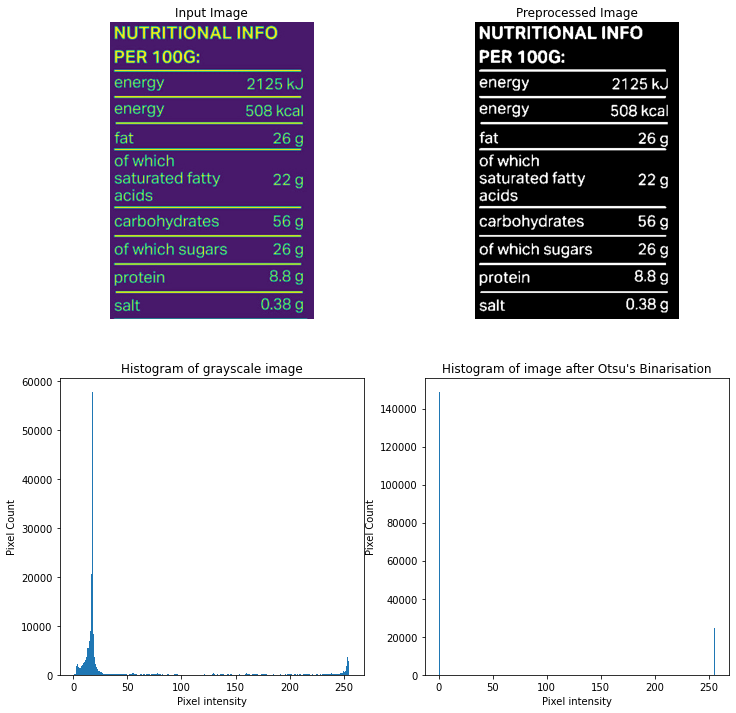

In [304]:
image_path = 'Nutritional_Facts/nf52.jpg'
img = cv.imread(image_path,0)  # read an image
img_dpi = set_image_dpi(image_path)
imgnew = cv.imread(img_dpi,0)   
img_bin = image_binarisation(imgnew)

fig = plt.figure(figsize=(12,12))
fig.add_subplot(2, 2, 1)
plt.axis("off")
plt.imshow(img)
plt.title("Input Image")
fig.add_subplot(2, 2, 2)
plt.axis("off")
plt.imshow(img_bin,'gray')
plt.title("Preprocessed Image")
fig.show()
fig.add_subplot(2, 2, 3)
plt.hist(imgnew.ravel(),256,[0,256]); 
plt.title("Histogram of grayscale image")
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Count")
fig.show()
fig.add_subplot(2, 2, 4)
plt.hist(img_bin.ravel(),256,[0,256]);
plt.title("Histogram of image after Otsu's Binarisation") 
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Count")
fig.show()


In [305]:
oem = 1
psm = 3
config = ('-l eng --oem {oem} --psm {psm}'.format(oem=oem,psm=psm))

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

food_string = pytesseract.image_to_string(img_bin,lang = 'eng',config = config)
extractedText = open("Extracted_Text.txt",'w')
extractedText.write(food_string)
extractedText.close()

In [306]:
with open('Extracted_Text.txt','r') as f:
    print(f.read())

NUTRITIONAL INFO
PER 100G:
energy 2125 kJ

energy 508 kcal
fat 26g
of which

saturated fatty 229
acids

carbohydrates 569
of which sugars 26g
protein 889g

salt 0.38 g



In [307]:
import pkg_resources
import re
from symspellpy import SymSpell, Verbosity

In [308]:
# Text parsing and nutrient data acquisition from file

with open('Extracted_Text.txt', 'r') as file :
  filedata = file.read()

# Replace and remove erroneous strings and characters from textfile
filedata = filedata.replace('Og', '0g')
filedata = filedata.replace('Omg', '0mg')
filedata = filedata.replace('Omcg', '0mcg')
filedata = filedata.replace('_', '')
filedata = filedata.replace('of which', '')
filedata = filedata.replace('Of which', '')
filedata = filedata.replace('includes', '')
filedata = filedata.replace('Includes', '')

# Write the file out again
with open('Extracted_Text.txt', 'w') as file:
  file.write(filedata)

def change_to_g(text):                              # Used to change 9 to g. ex) Protein 109 ---> Protein 10g
    search_ln = re.search("\d\s|\d$", text)
    if search_ln and search_ln.group().strip() == "9":
        index = search_ln.span()[0]
        text = text[:index] +"g"+ text[index+1:]

    search_lnq = re.search("\dmq\s|\dmq$", text)
    if search_lnq:
        index = search_lnq.span()[0] +2
        text = text[:index] +"g"+ text[index+1:]
    return text

nutrientLineList = []

with open('Extracted_Text.txt', 'r') as file:
    line_list = file.readlines()
for line in line_list:
    newline = change_to_g(line)
    search_ln = re.findall(r"(((?:\w+[ ]+)+)(\d+\.*\d*[ ]*)([a-zA-Z]+))", newline)  # Find all sentences with format: Nutrient quantity unit
    try:
        nutrientLineList.append(list(search_ln[0][1:4]))
    except:
        pass

for nutrient in nutrientLineList:
    print(nutrient)

['PER ', '100', 'G']
['energy ', '2125 ', 'kJ']
['energy ', '508 ', 'kcal']
['fat ', '26', 'g']
['saturated fatty ', '22', 'g']
['carbohydrates ', '56', 'g']
['sugars ', '26', 'g']
['protein ', '889', 'g']
['salt ', '0.38 ', 'g']


In [309]:
# Spell Checking and Correction using SymSpell

with open('nutrient.txt') as f:                 # Creates a master list of nutrients
    nutrientListMaster = f.read().splitlines()
nutrientListMaster = [word.lower() for word in nutrientListMaster]

def nutrientFinder(nutrient):                    # Checks if a given nutrient is present in the master list
    for nutrientMaster in nutrientListMaster:
        if nutrient in nutrientMaster:
            return [True,nutrientMaster]
    return [False,nutrient]

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)   # Custom list of nutrient names, which acts as the dictionary
corpus_path = "nutrient.txt"        
sym_spell.create_dictionary(corpus_path)
sym_spell.load_dictionary(corpus_path, term_index=0, count_index=1)
nutrientLineList_corrected = []

for word in nutrientLineList:           # Apply symspell spellchecking to each nutrient name
    index = nutrientLineList.index(word)
    input_term = (word[0].lower())
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)    # Find closest word in dictionary to the input
    for suggestion in suggestions:
        retVal = nutrientFinder(suggestion._term)
        if retVal[0] == True:
            nutrientLineList[index][0] = retVal[1]
            nutrientLineList_corrected.append(nutrientLineList[index])

for nutrient in nutrientLineList_corrected:
    print(nutrient)


['energy', '2125 ', 'kJ']
['energy', '508 ', 'kcal']
['fat', '26', 'g']
['saturated fatty acids', '22', 'g']
['carbohydrate', '56', 'g']
['sugars', '26', 'g']
['protein', '889', 'g']
['salt', '0.38 ', 'g']


In [310]:
import pandas as pd

NutritionTable = pd.DataFrame(columns = ["Nutrient","Quantity","Unit"]) # Create Dataframe to display nutrient list and quantity

for word in nutrientLineList_corrected:
    to_append = word
    df_length = len(NutritionTable)
    NutritionTable.loc[df_length] = to_append
    
NutritionTable.index += 1 
NutritionTable

,Nutrient,Quantity,Unit
1,energy,2125,kJ
2,energy,508,kcal
3,fat,26,g
4,saturated fatty acids,22,g
5,carbohydrate,56,g
6,sugars,26,g
7,protein,889,g
8,salt,0.38,g


In [ ]:

nutrient_dict = {
    "Calories": None,
    "Sugar (g)": None,
    "Fat (g)": None,
    "Protein (g)": None
}
for nutrient in NutritionTable:
    name = nutrient[0].strip().lower()
    value = float(nutrient[1].strip())
    if name == "energy" and nutrient[2].strip().lower() == "kcal":
        nutrient_dict["Calories"] = value
    elif name == "sugars":
        nutrient_dict["Sugar (g)"] = value
    elif name == "fat":
        nutrient_dict["Fat (g)"] = value
    elif name == "protein":
        nutrient_dict["Protein (g)"] = value
df = pd.DataFrame([nutrient_dict])

print("Training DataFrame:")
print(df)

Training DataFrame:
   Calories  Sugar (g)  Fat (g)  Protein (g)
0     508.0       26.0     26.0         8.89


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Sample dataset
data = r"D:\food_claims_data.csv"  
df = pd.read_csv(data)

features = ["Calories", "Sugar (g)", "Fat (g)", "Protein (g)"]
target = "Valid"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)



Accuracy: 0.9
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       173
           1       0.80      0.85      0.82        27

    accuracy                           0.90       200
   macro avg       0.84      0.88      0.86       200
weighted avg       0.89      0.90      0.88       200



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
test_data_scaled = scaler.transform(df)
prediction = svm_model.predict(test_data_scaled)
if prediction==1:
    print( "the claim is valid")
else:
    print("invalid claim")


the claim is valid


Accuracy: 0.85
Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       173
           1       0.75      0.66      0.70        27

    accuracy                           0.85       200
   macro avg       0.80      0.78      0.78       200
weighted avg       0.83      0.85      0.83       200



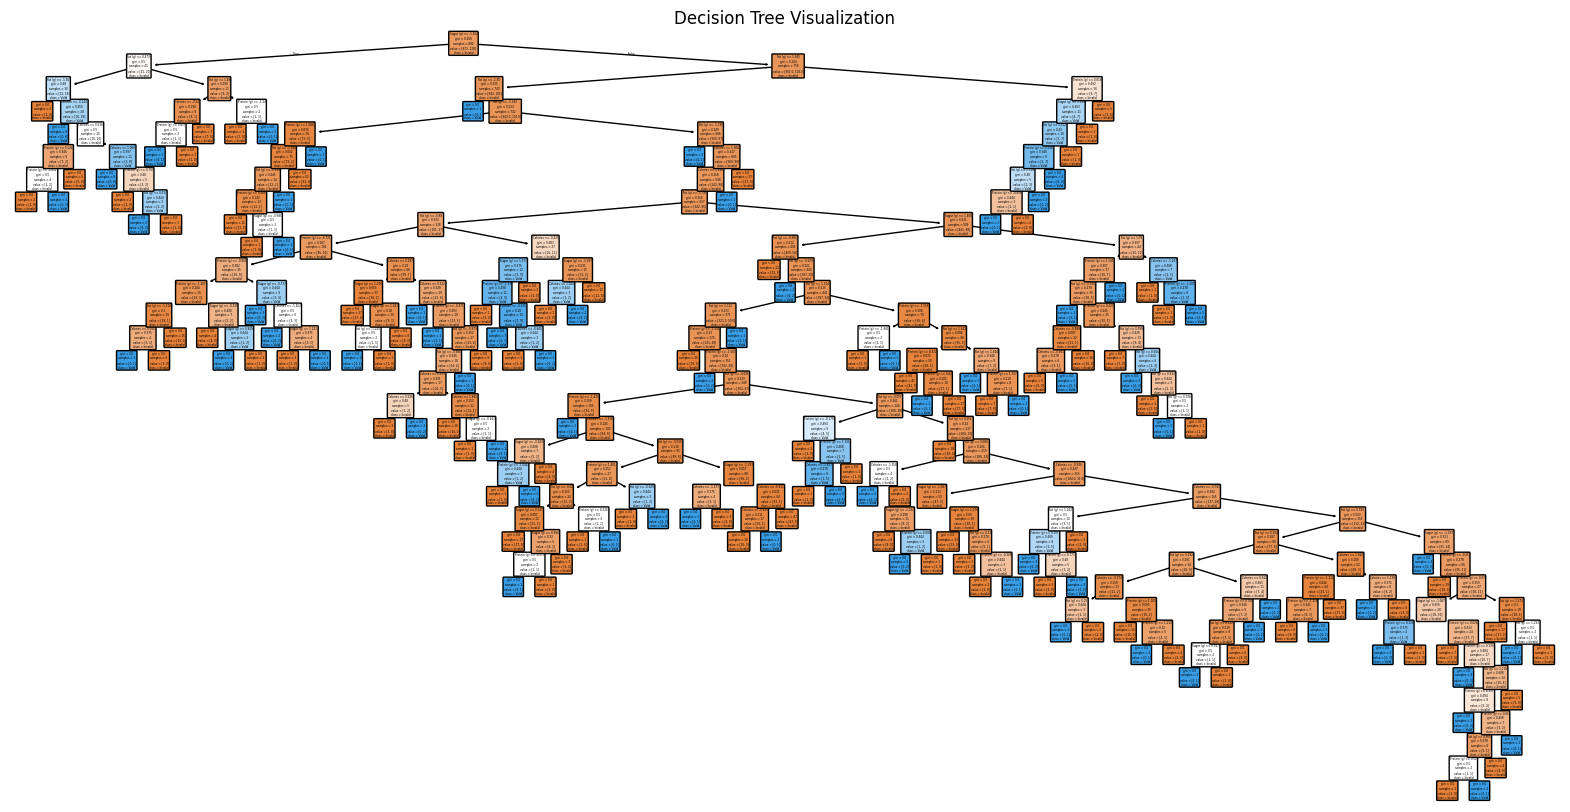


Feature Importances:
        Feature  Importance
3  Protein (g)    0.325085
2      Fat (g)    0.283888
0     Calories    0.225387
1    Sugar (g)    0.165640


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Correct import
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Dataset
data = r"D:\food_claims_data.csv"  
df = pd.read_csv(data)

features = ["Calories", "Sugar (g)", "Fat (g)", "Protein (g)"]
target = "Valid"
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt_model = DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=features, class_names=["Invalid", "Valid"], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance)


In [ ]:
prediction = dt_model.predict(test_data_scaled)
if prediction==1:
    print( "the claim is valid")
else:
    print("invalid claim")

the claim is valid


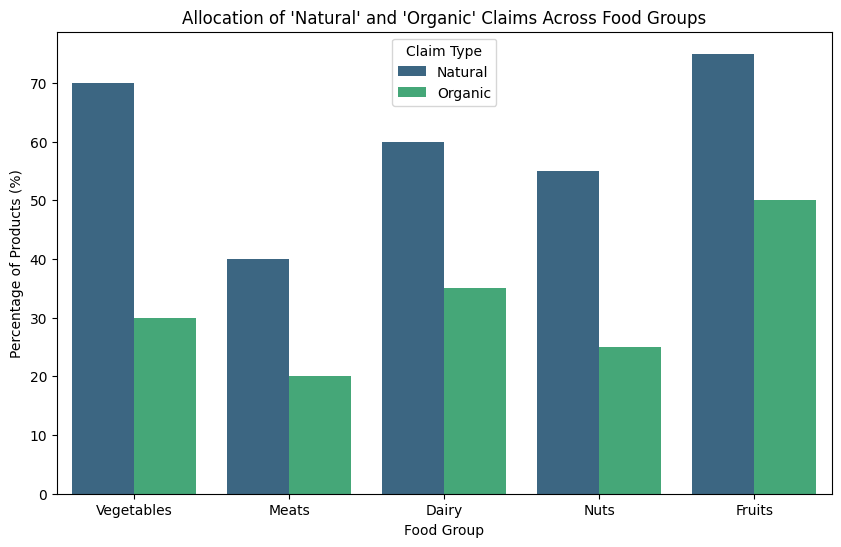

C:\Users\USER\AppData\Local\Temp\ipykernel_3136\4285479771.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=calorie_data, x="Food Group", y="Calories", palette="pastel")


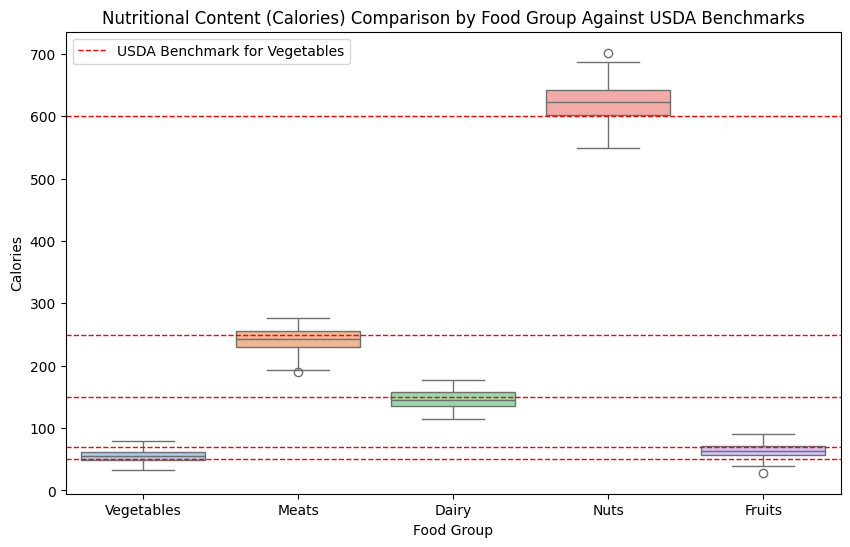

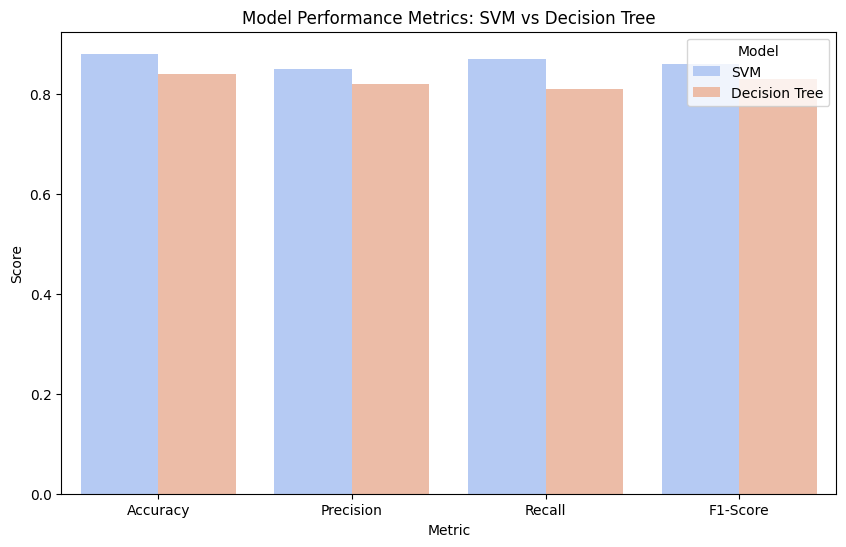

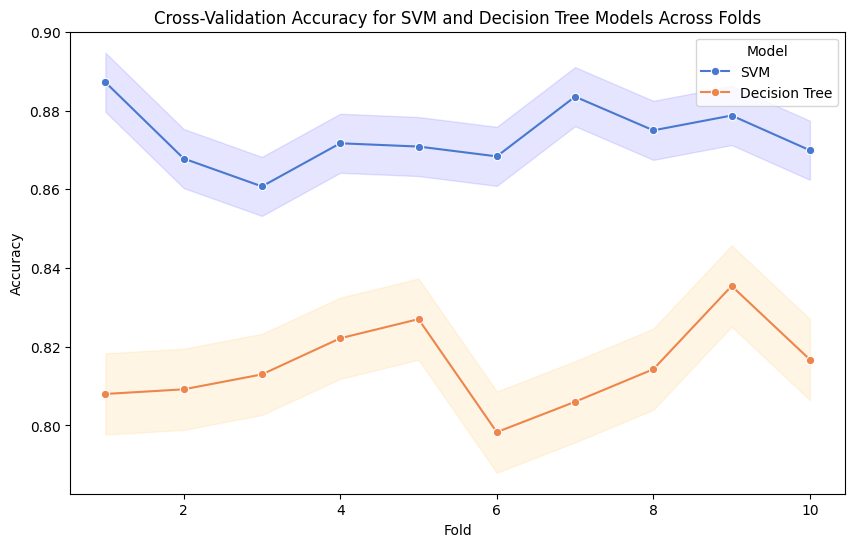

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_food_claims = pd.read_csv('food_claims.csv')  
df_nutritional_data = pd.read_csv('nutritional_data.csv')  
df_model_metrics = pd.read_csv('model_metrics.csv')  
df_cv_accuracy = pd.read_csv('cv_accuracy.csv')  
plt.figure(figsize=(10, 6))
sns.barplot(data=df_food_claims, x="Food Group", y="Percentage", hue="Claim Type", palette="viridis")
plt.title("Allocation of 'Natural' and 'Organic' Claims Across Food Groups")
plt.ylabel("Percentage of Products (%)")
plt.show()

# Plot 2: Nutritional Content Comparison Against USDA Benchmarks
# Assuming 'df_nutritional_data' has actual calories data for each food group
calorie_benchmarks = {
    "Vegetables": 50, "Meats": 250, "Dairy": 150, "Nuts": 600, "Fruits": 70
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_nutritional_data, x="Food Group", y="Calories", palette="pastel")
for i, fg in enumerate(calorie_benchmarks):
    plt.axhline(y=calorie_benchmarks[fg], color='r', linestyle='--', linewidth=1, label=f'USDA Benchmark for {fg}' if i == 0 else "")
plt.legend()
plt.title("Nutritional Content (Calories) Comparison by Food Group Against USDA Benchmarks")
plt.show()

# Plot 3: Model Performance Metrics Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_model_metrics, x="Metric", y="Score", hue="Model", palette="coolwarm")
plt.title("Model Performance Metrics: SVM vs Decision Tree")
plt.ylabel("Score")
plt.show()

# Plot 4: Cross-Validation Accuracy Across Multiple Folds
# Assuming 'df_cv_accuracy' has accuracy data for each fold and model
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cv_accuracy, x="Fold", y="Accuracy", hue="Model", marker='o', palette="muted")
plt.fill_between(df_cv_accuracy['Fold'][df_cv_accuracy['Model'] == "SVM"],
                 df_cv_accuracy[df_cv_accuracy['Model'] == "SVM"]['Accuracy'] - df_cv_accuracy[df_cv_accuracy['Model'] == "SVM"]['Accuracy'].std(),
                 df_cv_accuracy[df_cv_accuracy['Model'] == "SVM"]['Accuracy'] + df_cv_accuracy[df_cv_accuracy['Model'] == "SVM"]['Accuracy'].std(),
                 color='b', alpha=0.1)
plt.fill_between(df_cv_accuracy['Fold'][df_cv_accuracy['Model'] == "Decision Tree"],
                 df_cv_accuracy[df_cv_accuracy['Model'] == "Decision Tree"]['Accuracy'] - df_cv_accuracy[df_cv_accuracy['Model'] == "Decision Tree"]['Accuracy'].std(),
                 df_cv_accuracy[df_cv_accuracy['Model'] == "Decision Tree"]['Accuracy'] + df_cv_accuracy[df_cv_accuracy['Model'] == "Decision Tree"]['Accuracy'].std(),
                 color='orange', alpha=0.1)
plt.title("Cross-Validation Accuracy for SVM and Decision Tree Models Across Folds")
plt.ylabel("Accuracy")
plt.show()
